<a href="https://colab.research.google.com/github/capajaro/AnalisisResults/blob/main/Comparison_GMPEs_MNRS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GMPEs in openquake.hazardlib
<tt>

LICENSE

Copyright (c) 2014, GEM Foundation, G. Weatherill, M. Pagani, D. Monelli.

The notebook is free software: you can redistribute
it and/or modify it under the terms of the GNU Affero General Public
License as published by the Free Software Foundation, either version
3 of the License, or (at your option) any later version.

You should have received a copy of the GNU Affero General Public License
along with OpenQuake. If not, see <http://www.gnu.org/licenses/>

DISCLAIMER

The notebook provided herein is released as a prototype
implementation on behalf of scientists and engineers working within the GEM
Foundation (Global Earthquake Model).

It is distributed for the purpose of open collaboration and in the
hope that it will be useful to the scientific, engineering, disaster
risk and software design communities.

The software is NOT distributed as part of GEM's OpenQuake suite
(http://www.globalquakemodel.org/openquake) and must be considered as a
separate entity. The software provided herein is designed and implemented
by scientific staff. It is not developed to the design standards, nor
subject to same level of critical review by professional software
developers, as GEM's OpenQuake software suite.

Feedback and contribution to the software is welcome, and can be
directed to the hazard scientific staff of the GEM Model Facility
(hazard@globalquakemodel.org).

The notebook is therefore distributed WITHOUT ANY WARRANTY; without
even the implied warranty of MERCHANTABILITY or FITNESS FOR A PARTICULAR
PURPOSE. See the GNU General Public License for more details.

The GEM Foundation, and the authors of the software, assume no liability for
use of the software.
</tt>

In [177]:
%%capture
!pip install openquake.engine

In [178]:
%matplotlib inline

from openquake.hazardlib.gsim import get_available_gsims
from openquake.hazardlib.source import PointSource
from openquake.hazardlib.mfd import TruncatedGRMFD
from openquake.hazardlib.scalerel import WC1994
from openquake.hazardlib.geo import Point, NodalPlane, Line
from openquake.hazardlib.pmf import PMF
from openquake.hazardlib.tom import PoissonTOM
from openquake.hazardlib.site import Site, SiteCollection
from openquake.hazardlib.imt import PGA
from openquake.hazardlib.const import StdDev
from openquake.hazardlib.gsim.base import ContextMaker
from openquake.hazardlib.const import TRT
from openquake.hazardlib import valid
from openquake.hazardlib.contexts import *  # for backward compatibility
import numpy

from matplotlib import pyplot, collections
from matplotlib.colorbar import cm
from collections import OrderedDict

# Retrieve available GMPEs

In [179]:
# list available GMPEs
get_available_gsims().keys()

dict_keys(['AbrahamsonEtAl2014', 'AbrahamsonEtAl2014NSHMPLower', 'AbrahamsonEtAl2014NSHMPMean', 'AbrahamsonEtAl2014NSHMPUpper', 'AbrahamsonEtAl2014RegCHN', 'AbrahamsonEtAl2014RegJPN', 'AbrahamsonEtAl2014RegTWN', 'AbrahamsonEtAl2015SInter', 'AbrahamsonEtAl2015SInterHigh', 'AbrahamsonEtAl2015SInterLow', 'AbrahamsonEtAl2015SInter_scaled', 'AbrahamsonEtAl2015SSlab', 'AbrahamsonEtAl2015SSlabHigh', 'AbrahamsonEtAl2015SSlabLow', 'AbrahamsonEtAl2015SSlab_scaled', 'AbrahamsonEtAl2018SInter', 'AbrahamsonEtAl2018SInterHigh', 'AbrahamsonEtAl2018SInterLow', 'AbrahamsonEtAl2018SSlab', 'AbrahamsonEtAl2018SSlabHigh', 'AbrahamsonEtAl2018SSlabLow', 'AbrahamsonGulerce2020SInter', 'AbrahamsonGulerce2020SInterAlaska', 'AbrahamsonGulerce2020SInterCascadia', 'AbrahamsonGulerce2020SInterCentralAmericaMexico', 'AbrahamsonGulerce2020SInterJapan', 'AbrahamsonGulerce2020SInterNewZealand', 'AbrahamsonGulerce2020SInterSouthAmerica', 'AbrahamsonGulerce2020SInterTaiwan', 'AbrahamsonGulerce2020SSlab', 'AbrahamsonGuler

# Explore GMPEs metadata

In [180]:
for i, (name, gmpe) in enumerate(get_available_gsims().items()):
    print(name)
    print(gmpe.DEFINED_FOR_TECTONIC_REGION_TYPE)
    print('supported tectonic region: ', gmpe.DEFINED_FOR_TECTONIC_REGION_TYPE)
    print('supported intensity measure types: ', [imt.__name__ for imt in gmpe.DEFINED_FOR_INTENSITY_MEASURE_TYPES])
    print('supported component: ', gmpe.DEFINED_FOR_INTENSITY_MEASURE_COMPONENT)
    print('supported standard deviations: ', gmpe.DEFINED_FOR_STANDARD_DEVIATION_TYPES)
    print('required site parameters: ' , gmpe.REQUIRES_SITES_PARAMETERS)
    print('required rupture parameters: ', gmpe.REQUIRES_RUPTURE_PARAMETERS)
    print('required distance parameters: ',gmpe.REQUIRES_DISTANCES)
    print('')
#    if i > 3:
#        break

Se han truncado las últimas 5000 líneas del flujo de salida.
DouglasEtAl2013StochasticSD010Q600K040
TRT.GEOTHERMAL
supported tectonic region:  TRT.GEOTHERMAL
supported intensity measure types:  ['PGA', 'PGV', 'SA']
supported component:  IMC.GEOMETRIC_MEAN
supported standard deviations:  frozenset({'Total', 'Intra event', 'Inter event'})
required site parameters:  frozenset()
required rupture parameters:  frozenset({'mag'})
required distance parameters:  frozenset({'rhypo'})

DouglasEtAl2013StochasticSD010Q600K060
TRT.GEOTHERMAL
supported tectonic region:  TRT.GEOTHERMAL
supported intensity measure types:  ['PGA', 'PGV', 'SA']
supported component:  IMC.GEOMETRIC_MEAN
supported standard deviations:  frozenset({'Total', 'Intra event', 'Inter event'})
required site parameters:  frozenset()
required rupture parameters:  frozenset({'mag'})
required distance parameters:  frozenset({'rhypo'})

DouglasEtAl2013StochasticSD100Q1800K005
TRT.GEOTHERMAL
supported tectonic region:  TRT.GEOTHERMAL
sup

# Explore GMPEs magnitude scaling

In [197]:
# select a number of GMPEs for which we want to analyze the magnitude scaling

gmpes = [
    valid.gsim('AbrahamsonEtAl2014'),
    valid.gsim('CauzziEtAl2014'),
    #valid.gsim('Idriss2014'),
    valid.gsim('BooreEtAl2014'),
    valid.gsim('CampbellBozorgnia2014'),
    valid.gsim('ChiouYoungs2014'),
    # valid.gsim('AbrahamsonEtAl2015SInter'),
]

In [198]:
# explore magnitude scaling, by defining a Point source and calculating median ground shaking at the point
# source location
src = PointSource(
    source_id='1',
    name='point',
    tectonic_region_type='Active Shallow Crust',
    mfd=TruncatedGRMFD(min_mag=5., max_mag=7.55, bin_width=0.1, a_val=0.01, b_val=0.98),
    rupture_mesh_spacing=2.,
    magnitude_scaling_relationship=WC1994(),
    rupture_aspect_ratio=1.,
    temporal_occurrence_model=PoissonTOM(50.),
    upper_seismogenic_depth=2.,
    lower_seismogenic_depth=12.,
    location=Point(9, 45),
    nodal_plane_distribution=PMF([(1., NodalPlane(strike=45, dip=50, rake=0))]),
    hypocenter_distribution=PMF([(1, 7.)])
)
vs30 = 360

# this is the site for which we compute the median ground shaking
site_collection = SiteCollection([Site(location=Point(9.25, 45.25), vs30=vs30, vs30measured=True, z1pt0=40., z2pt5=1.0)])

# this is the intensity measure type for which we compute the median ground shaking
imts = ['PGA', 'SA(0.3)', 'SA(1.0)', 'SA(10.0)']
#imts = ['PGA',]
imtls = {s: [0] for s in imts} #required for context maker, M = 3 IMTs

In [199]:
# use all ruptures, for each rupture extract magnitude and median value
context_maker = ContextMaker('*',gmpes,{'imtls': imtls}) #builds all necessary contexts
ruptures = [r for r in src.iter_ruptures()]
mags = [r.mag for r in ruptures]

In [200]:
ctxs = list(context_maker.get_ctx_iter(ruptures,site_collection)) #builds rupture context
gms = context_maker.get_mean_stds(ctxs) #(4, G, M, N)

Text(0, 0.5, '$R_{Rup}$ [km]')

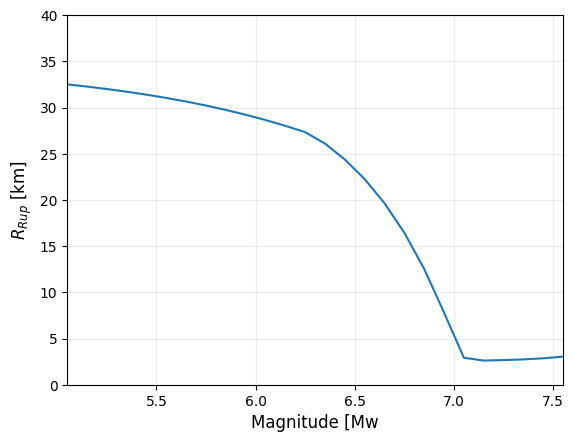

In [201]:
pyplot.plot(ctxs[0].mag, ctxs[0].rrup)
pyplot.grid(which = 'both', alpha = 0.25)
pyplot.xlim([numpy.min(mags),numpy.max(mags)])
pyplot.ylim([0,40])
pyplot.xlabel('Magnitude [Mw', fontsize=12)
pyplot.ylabel('$R_{Rup}$ [km]', fontsize=12)


In [202]:
gms.shape #first 4 are median, std_total, std_intra, std_inter; then G=2 gsims, M=3 IMTs, 15 scenarios = magnitudes

(4, 5, 4, 26)

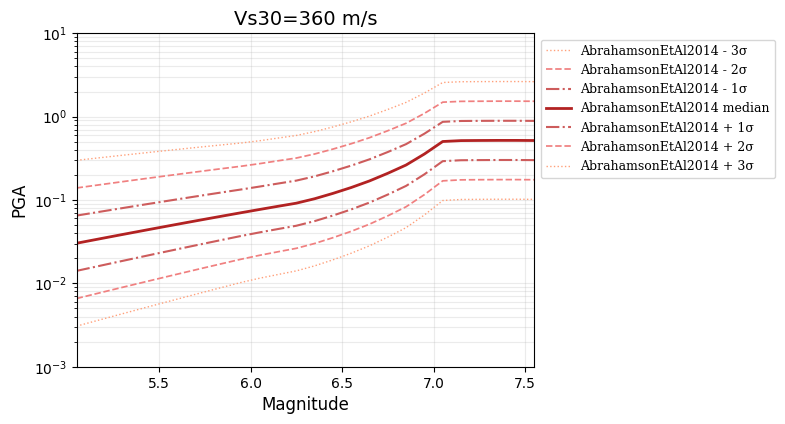

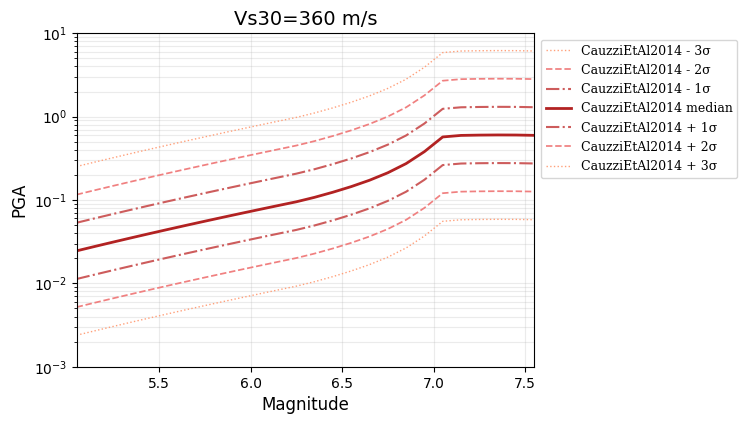

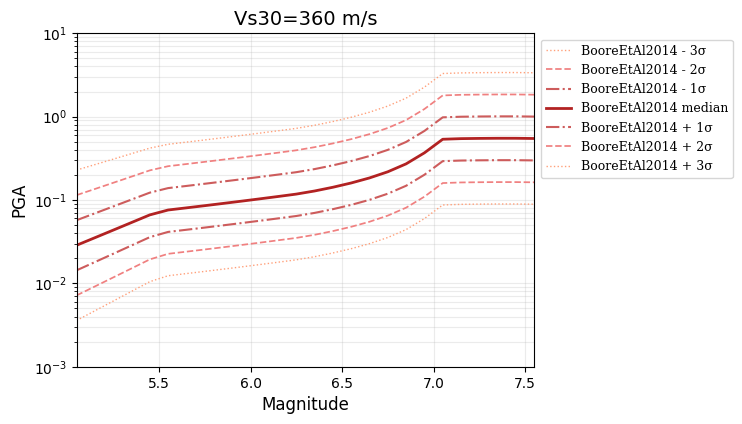

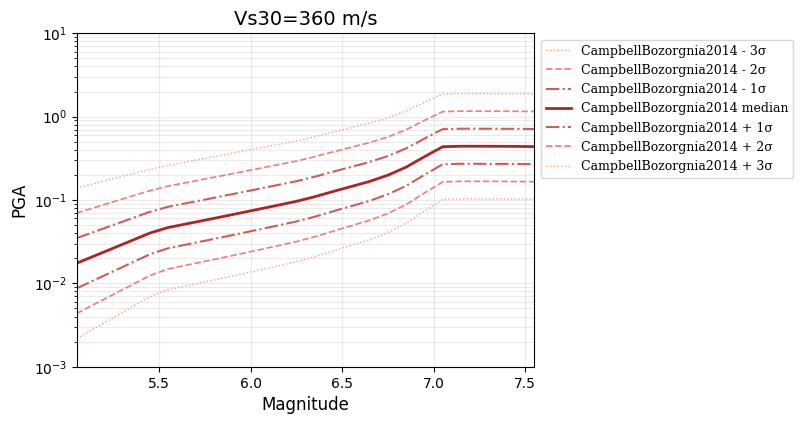

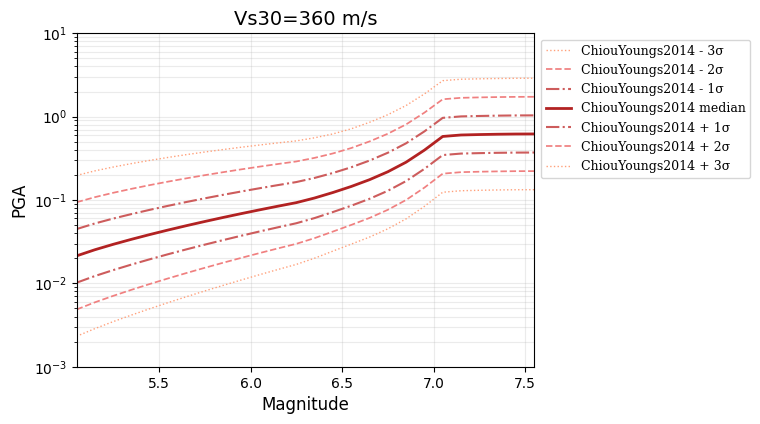

In [203]:
# plot magnitude scaling
imt = 0

for i_gsim in range(len(gmpes)):
  gsim = i_gsim
  fig = pyplot.figure(figsize=(15/2.54,11/2.54))

  pyplot.semilogy(mags, numpy.exp(gms[0,gsim,imt] - 3*gms[1,gsim,imt]), linewidth=1, color='LightSalmon', linestyle='dotted', label=gmpes[gsim].__class__.__name__ + ' - 3σ')
  pyplot.semilogy(mags, numpy.exp(gms[0,gsim,imt] - 2*gms[1,gsim,imt]), linewidth=1.25, color='LightCoral', linestyle='dashed', label=gmpes[gsim].__class__.__name__ + ' - 2σ')
  pyplot.semilogy(mags, numpy.exp(gms[0,gsim,imt] - 1*gms[1,gsim,imt]), linewidth=1.5, color='IndianRed', linestyle='dashdot', label=gmpes[gsim].__class__.__name__ + ' - 1σ')
  pyplot.semilogy(mags, numpy.exp(gms[0,gsim,imt]), linewidth=2, color='FireBrick', linestyle='solid', label=gmpes[gsim].__class__.__name__ + ' median')
  pyplot.semilogy(mags, numpy.exp(gms[0,gsim,imt] + 1*gms[1,gsim,imt]), linewidth=1.5, color='IndianRed', linestyle='dashdot', label=gmpes[gsim].__class__.__name__ + ' + 1σ')
  pyplot.semilogy(mags, numpy.exp(gms[0,gsim,imt] + 2*gms[1,gsim,imt]), linewidth=1.25, color='LightCoral', linestyle='dashed', label=gmpes[gsim].__class__.__name__ + ' + 2σ')
  pyplot.semilogy(mags, numpy.exp(gms[0,gsim,imt] + 3*gms[1,gsim,imt]), linewidth=1, color='LightSalmon', linestyle='dotted', label=gmpes[gsim].__class__.__name__ + ' + 3σ')
  pyplot.grid(which = 'both', alpha = 0.25)
  pyplot.xlim([numpy.min(mags),numpy.max(mags)])
  pyplot.ylim([1e-3,10])
  pyplot.xlabel('Magnitude', fontsize=12)
  pyplot.ylabel(imts[imt], fontsize=12)
  pyplot.title('Vs30=%d m/s' % ( vs30), fontsize=14)
  pyplot.legend(loc="best", bbox_to_anchor=(1,1), prop = {'family':'serif', 'size':9});

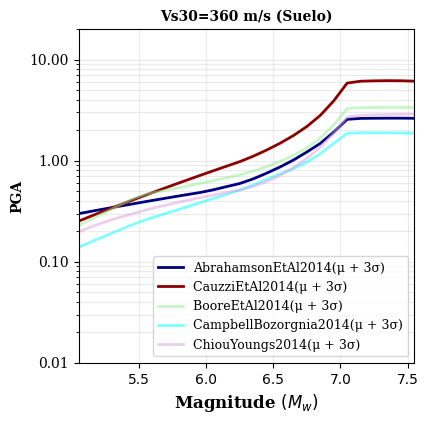

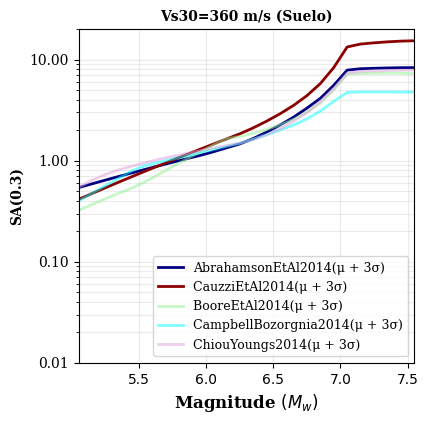

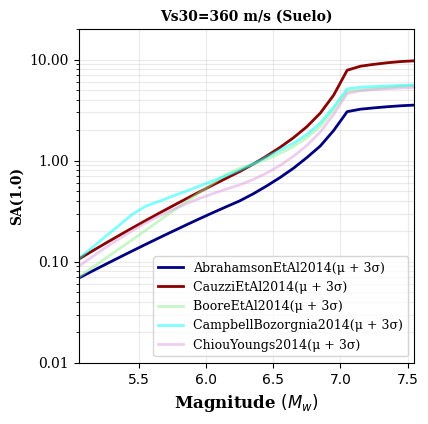

In [217]:
# plot magnitude scaling
#Colors_GMMS = ['navy', 'darkred', 'darkorange', 'lightgreen', 'cyan', 'plum']
Colors_GMMS = ['navy', 'darkred', 'lightgreen', 'cyan', 'plum']
alpha_GMMS = [1,1,0.5,0.5,0.5,0.5]
n_sigmas = 3
for imt in range(3):
  fig = pyplot.figure(figsize=(11/2.54,11/2.54))

  for i_gsim in range(len(gmpes)):
    gsim = i_gsim
    if n_sigmas == 0:
      label_line = gmpes[gsim].__class__.__name__ + '(\u03bc)'
      pyplot.semilogy(mags, numpy.exp(gms[0,gsim,imt] + n_sigmas*gms[1,gsim,imt]), linewidth=2, color=Colors_GMMS[i_gsim], label=label_line, alpha = alpha_GMMS[i_gsim])
    else:
      label_line = gmpes[gsim].__class__.__name__ + '(\u03bc + %0.0fσ)'%(n_sigmas)
      pyplot.semilogy(mags, numpy.exp(gms[0,gsim,imt] + n_sigmas*gms[1,gsim,imt]), linewidth=2, color=Colors_GMMS[i_gsim], label=label_line, alpha = alpha_GMMS[i_gsim])
    pyplot.grid(which = 'both', alpha = 0.25)
    pyplot.xlim([numpy.min(mags),numpy.max(mags)])
    tickmarks = [0.01,0.1,1,10]
    ticklabs = ['%0.2f'%(el) for el in tickmarks]
    pyplot.yticks(ticks = tickmarks, labels = ticklabs, fontdict={'fontsize': 10, 'fontname': 'serif'})
    pyplot.ylim([1e-2,20])
    tag_soil = 'Roca' if vs30 >= 550 else 'Suelo'
    pyplot.title('Vs30=%d m/s (%s)' % (vs30, tag_soil), fontdict={'fontsize': 10, 'fontname': 'serif', 'fontweight': 'bold'})

    pyplot.xlabel('Magnitude $(M_w)$', fontdict={'fontsize': 12, 'fontname': 'serif', 'fontweight': 'bold'})
    pyplot.ylabel(imts[imt], fontdict={'fontsize': 10, 'fontname': 'serif', 'fontweight': 'bold'})


    pyplot.legend(loc="lower right", prop = {'family':'serif', 'size':9});

In [221]:
imt = 0
print(numpy.min((numpy.exp(gms[0,1,imt] + n_sigmas*gms[1,1,imt])/numpy.exp(gms[0,0,imt] + n_sigmas*gms[1,0,imt]))))
print(numpy.max((numpy.exp(gms[0,1,imt] + n_sigmas*gms[1,1,imt])/numpy.exp(gms[0,0,imt] + n_sigmas*gms[1,0,imt]))))

0.8430536980986251
2.35191757077794


In [220]:
imt = 1
print(numpy.min((numpy.exp(gms[0,1,imt] + n_sigmas*gms[1,1,imt])/numpy.exp(gms[0,0,imt] + n_sigmas*gms[1,0,imt]))))
print(numpy.max((numpy.exp(gms[0,1,imt] + n_sigmas*gms[1,1,imt])/numpy.exp(gms[0,0,imt] + n_sigmas*gms[1,0,imt]))))

0.7662417613421861
1.8452100950327934


In [218]:
print(numpy.min((numpy.exp(gms[0,1,imt] + n_sigmas*gms[1,1,imt])/numpy.exp(gms[0,0,imt] + n_sigmas*gms[1,0,imt]))))
print(numpy.max((numpy.exp(gms[0,1,imt] + n_sigmas*gms[1,1,imt])/numpy.exp(gms[0,0,imt] + n_sigmas*gms[1,0,imt]))))

1.541977320831385
2.7431065198779243


In [122]:
imt = 0
gsim = 4
n_sigmas = 0
print(gmpes[gsim])

numpy.exp(gms[0,gsim,imt] + n_sigmas*gms[1,gsim,imt])

[CampbellBozorgnia2014]


array([0.01742067, 0.02145617, 0.02642808, 0.03255079, 0.04008504,
       0.04675669, 0.05170082, 0.05721435, 0.06337099, 0.07025511,
       0.07796326, 0.0866058 , 0.09630837, 0.10927954, 0.12631224,
       0.14509157, 0.16682614, 0.19835031, 0.24772316, 0.33065528,
       0.43561289, 0.44142583, 0.44120405, 0.44058402, 0.43933713,
       0.43708426])

# Explore GMPEs distance scaling

In [123]:
# define JB distance for which calculating mean ground shaking
jb_distances = numpy.arange(0, 51, 1)

# extract last rupture
rupture = ruptures[-1]

# get coordinates of surface projection of bottom edge mid point
bottom_edge = Line([rupture.surface.bottom_left, rupture.surface.bottom_right])
bottom_edge = bottom_edge.resample_to_num_points(3)
mid_point = bottom_edge[1]
mid_point.depth = 0.

# compute coordinates of locations that are at jb_distances from bottom edge mid point
# along a direction that is perpendicular to the rupture strike
locs = [mid_point.point_at(horizontal_distance=d, vertical_increment=0, azimuth=rupture.surface.strike + 90.)
        for d in jb_distances]

In [124]:
# create corresponding site collection
site_collection = SiteCollection([Site(location=loc, vs30=vs30, vs30measured=True, z1pt0=40., z2pt5=1.) for loc in locs])

In [125]:
# use all ruptures, for each rupture extract magnitude and median value
context_maker = ContextMaker('*',gmpes,{'imtls': imtls}) #builds all necessary contexts
ctxs = list(context_maker.get_ctx_iter([rupture],site_collection)) #builds rupture context
gms = context_maker.get_mean_stds(ctxs) #(4, G, M, N)

In [126]:
gms.shape #first 4 are median, std_total, std_intra, std_inter; then G=2 gsims, M=2 IMTs, 15 scenarios = sites/distances

(4, 6, 4, 51)

In [127]:
#print distances context maker created (check back what we have set above...)
ctxs[0].rjb

array([ 0.        ,  0.14075189,  1.14070264,  2.14065339,  3.14060415,
        4.1405549 ,  5.14050566,  6.14045641,  7.14040716,  8.14035792,
        9.14030867, 10.14025942, 11.14021018, 12.14016093, 13.14011168,
       14.14006244, 15.14001319, 16.13996394, 17.1399147 , 18.13986545,
       19.1398162 , 20.13976696, 21.13971771, 22.13966846, 23.13961922,
       24.13956997, 25.13952072, 26.13947147, 27.13942223, 28.13937298,
       29.13932373, 30.13927449, 31.13922524, 32.13917599, 33.13912674,
       34.13907749, 35.13902825, 36.138979  , 37.13892975, 38.1388805 ,
       39.13883125, 40.13878201, 41.13873276, 42.13868351, 43.13863426,
       44.13858501, 45.13853576, 46.13848651, 47.13843727, 48.13838802,
       49.13833877])

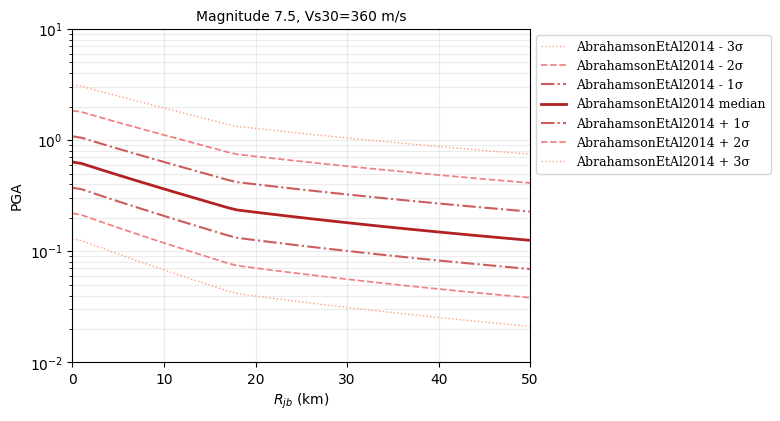

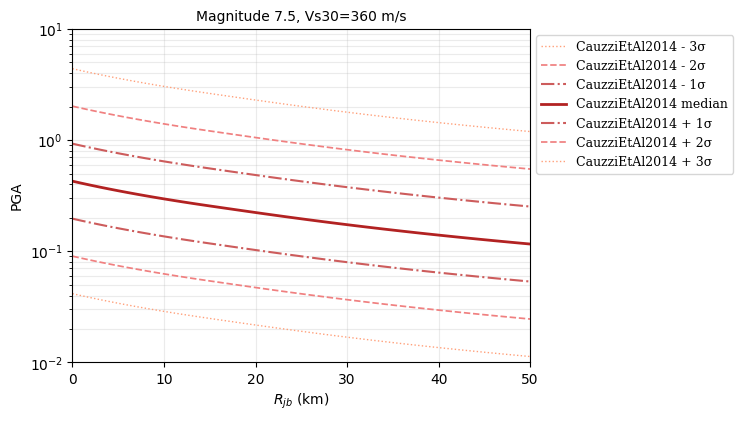

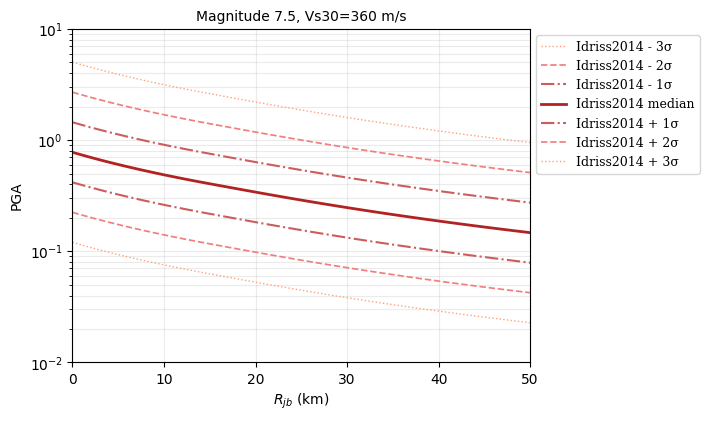

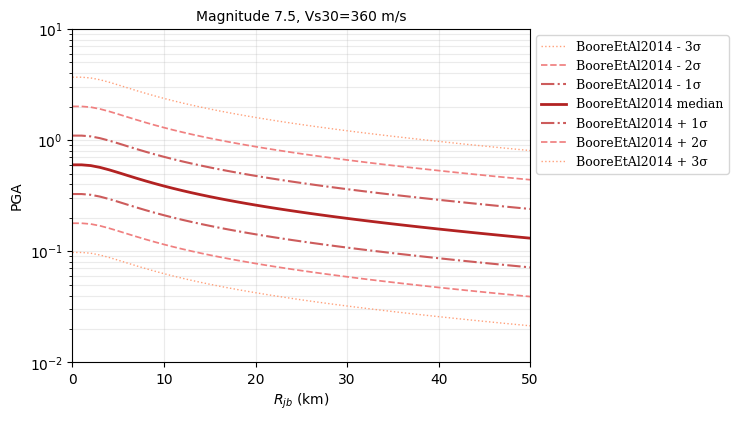

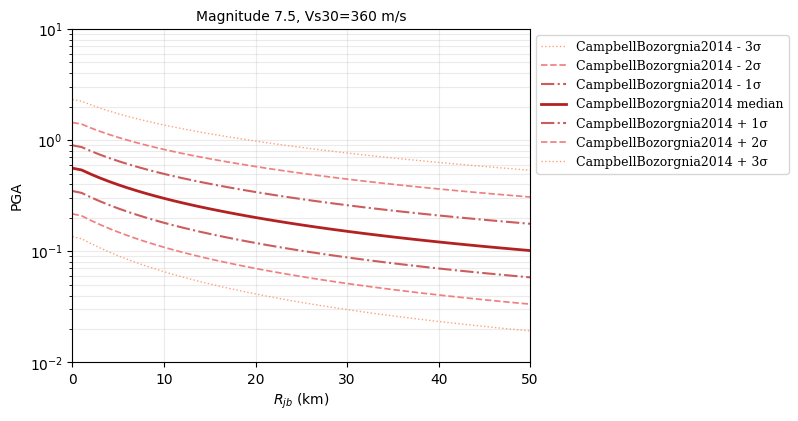

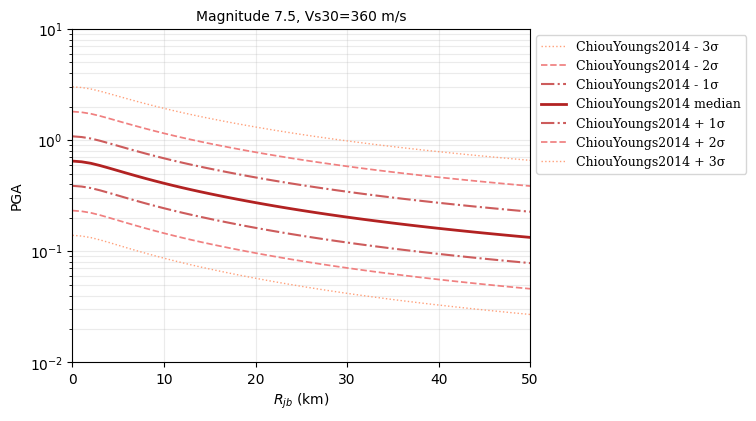

In [128]:
# plot distance scaling
imt = 0

for i_gsim in range(len(gmpes)):
  gsim = i_gsim
  fig = pyplot.figure(figsize=(15/2.54,11/2.54))


  pyplot.semilogy(jb_distances, numpy.exp(gms[0,gsim,imt] - 3*gms[1,gsim,imt]), linewidth=1, color='LightSalmon', linestyle='dotted', label=gmpes[gsim].__class__.__name__ + ' - 3σ')
  pyplot.semilogy(jb_distances, numpy.exp(gms[0,gsim,imt] - 2*gms[1,gsim,imt]), linewidth=1.25, color='LightCoral', linestyle='dashed', label=gmpes[gsim].__class__.__name__ + ' - 2σ')
  pyplot.semilogy(jb_distances, numpy.exp(gms[0,gsim,imt] - 1*gms[1,gsim,imt]), linewidth=1.5, color='IndianRed', linestyle='dashdot', label=gmpes[gsim].__class__.__name__ + ' - 1σ')
  pyplot.semilogy(jb_distances, numpy.exp(gms[0,gsim,imt]), linewidth=2, color='FireBrick', linestyle='solid', label=gmpes[gsim].__class__.__name__ + ' median')
  pyplot.semilogy(jb_distances, numpy.exp(gms[0,gsim,imt] + 1*gms[1,gsim,imt]), linewidth=1.5, color='IndianRed', linestyle='dashdot', label=gmpes[gsim].__class__.__name__ + ' + 1σ')
  pyplot.semilogy(jb_distances, numpy.exp(gms[0,gsim,imt] + 2*gms[1,gsim,imt]), linewidth=1.25, color='LightCoral', linestyle='dashed', label=gmpes[gsim].__class__.__name__ + ' + 2σ')
  pyplot.semilogy(jb_distances, numpy.exp(gms[0,gsim,imt] + 3*gms[1,gsim,imt]), linewidth=1, color='LightSalmon', linestyle='dotted', label=gmpes[gsim].__class__.__name__ + ' + 3σ')
  pyplot.grid(which = 'both', alpha = 0.25)
  pyplot.xlim([numpy.min(jb_distances),numpy.max(jb_distances)])
  pyplot.ylim([1e-2,10])
  pyplot.xlabel(r'$R_{jb}$ (km)', fontsize=10)
  pyplot.ylabel(imts[imt], fontsize=10)
  pyplot.title('Magnitude %.1f, Vs30=%d m/s' % (rupture.mag, vs30), fontsize=10)
  pyplot.legend(loc="best", bbox_to_anchor=(1,1), prop = {'family':'serif', 'size':9});


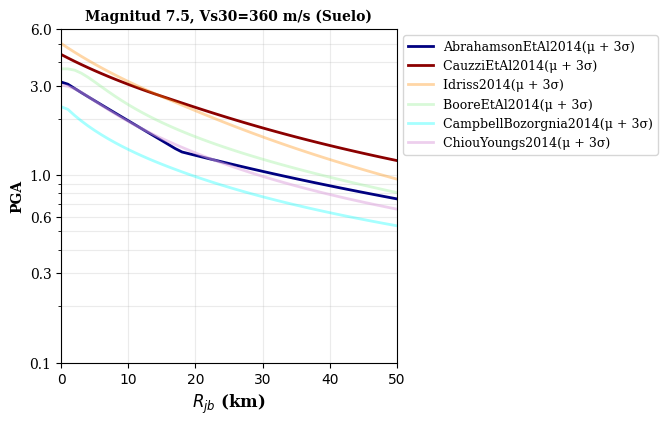

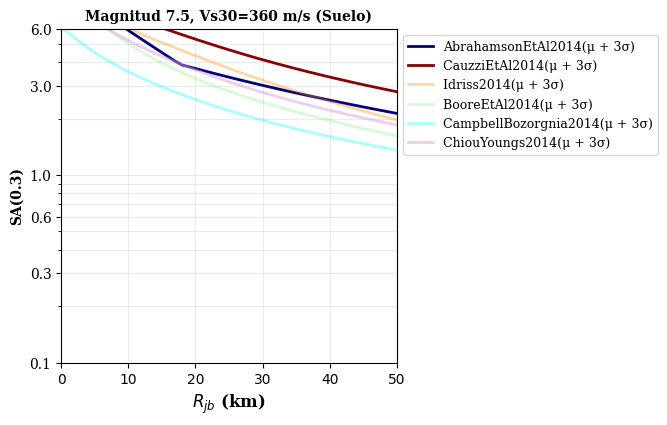

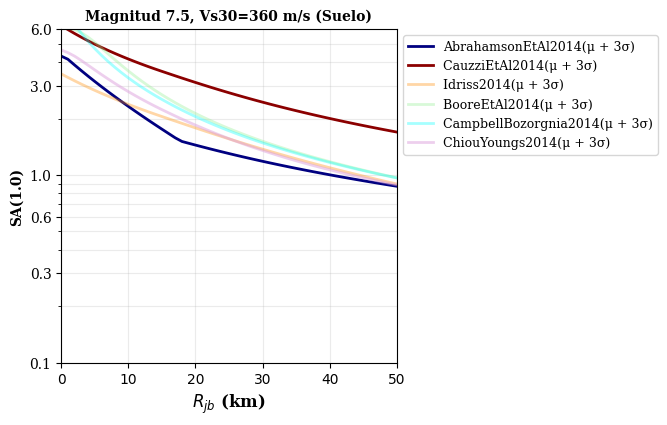

In [139]:
# plot distance scaling
Colors_GMMS = ['navy', 'darkred', 'darkorange', 'lightgreen', 'cyan', 'plum']
alpha_GMMS = [1,1,0.35,0.35,0.35,0.5]
n_sigmas = 3

for imt in range(3):
  fig = pyplot.figure(figsize=(11/2.54,11/2.54))

  for i_gsim in range(len(gmpes)):
    gsim = i_gsim
    if n_sigmas == 0:
      label_line = gmpes[gsim].__class__.__name__ + '(\u03bc)'
      pyplot.semilogy(jb_distances, numpy.exp(gms[0,gsim,imt] + n_sigmas*gms[1,gsim,imt]), linewidth=2, color=Colors_GMMS[i_gsim], label=label_line, alpha = alpha_GMMS[i_gsim])
    else:
      label_line = gmpes[gsim].__class__.__name__ + '(\u03bc + %0.0fσ)'%(n_sigmas)
      pyplot.semilogy(jb_distances, numpy.exp(gms[0,gsim,imt] + n_sigmas*gms[1,gsim,imt]), linewidth=2, color=Colors_GMMS[i_gsim], label=label_line, alpha = alpha_GMMS[i_gsim])
    pyplot.grid(which = 'both', alpha = 0.25)
    pyplot.xlim([numpy.min(jb_distances),numpy.max(jb_distances)])
    #tickmarks = numpy.arange(0.1,1,0.1)
    tickmarks = [0.1,0.3,0.6,1,3,6]
    ticklabs = ['%0.1f'%(el) for el in tickmarks]
    pyplot.yticks(ticks = tickmarks, labels = ticklabs, fontdict={'fontsize': 10, 'fontname': 'serif'})
    pyplot.ylim([0.1,6])
    pyplot.xlabel(r'$R_{jb}$ (km)', fontdict={'fontsize': 12, 'fontname': 'serif', 'fontweight': 'bold'})
    pyplot.ylabel(imts[imt], fontdict={'fontsize': 10, 'fontname': 'serif', 'fontweight': 'bold'})
    tag_soil = 'Roca' if vs30 >= 550 else 'Suelo'
    pyplot.title('Magnitud %.1f, Vs30=%d m/s (%s)' % (rupture.mag, vs30, tag_soil), fontdict={'fontsize': 10, 'fontname': 'serif', 'fontweight': 'bold'})
    pyplot.legend(loc="best", bbox_to_anchor=(1,1), prop = {'family':'serif', 'size':9});


In [148]:
print(numpy.min((numpy.exp(gms[0,1,imt] + n_sigmas*gms[1,1,imt])/numpy.exp(gms[0,0,imt] + n_sigmas*gms[1,0,imt]))))
print(numpy.max((numpy.exp(gms[0,1,imt] + n_sigmas*gms[1,1,imt])/numpy.exp(gms[0,0,imt] + n_sigmas*gms[1,0,imt]))))

1.439440383250658
2.178096955581691
